In [111]:
import logging

import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from ev_station_solver.constants import CONSTANTS
from ev_station_solver.helper_functions import get_distance_matrix
from ev_station_solver.loading import load_locations
from ev_station_solver.logging import get_logger
from ev_station_solver.solving.solver import Solver
from sklearn.cluster import KMeans

logger = get_logger(__name__, logging.DEBUG)

# Try to find initial locations, deterministically...

In [112]:
# use given starting solutions
locations = load_locations("medium").values
n_clusters = int(len(locations) * CONSTANTS["mu_charging"] / (2 * CONSTANTS["station_ub"]))
service_level = 0.95

n_clusters = 3 if n_clusters < 3 else n_clusters
n_clusters

28

In [171]:
# current approach with k means
s = Solver(vehicle_locations=locations, loglevel=logging.INFO, service_level=service_level)

# compute number of initial locations
s.add_initial_locations(n_clusters, mode="k-means", seed=0)
s.add_samples(num=20)

2025-01-15 13:52:42,844 - ev_station_solver.solving.solver - INFO - add_initial_locations: Added 28 k-means locations. Total number of locations: 28.
2025-01-15 13:52:42,887 - ev_station_solver.solving.solver - INFO - add_samples: Added 20 samples.


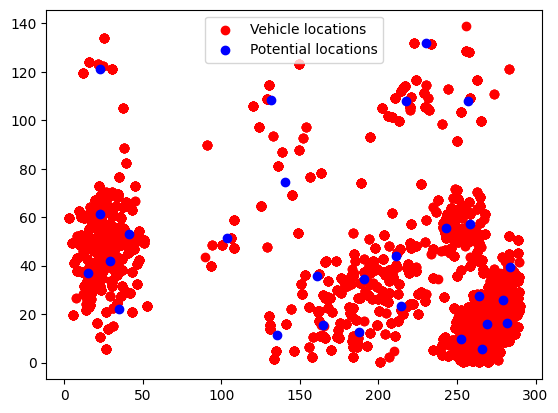

In [172]:
plt.scatter(s.vehicle_locations[:, 0], s.vehicle_locations[:, 1], c="red", label="Vehicle locations")
plt.scatter(s.coordinates_potential_cl[:, 0], s.coordinates_potential_cl[:, 1], c="blue", label="Potential locations")
plt.legend()
plt.show()

# Update Approach
Try to compute a set of initial locations based on the adjacency matrices.

Create a dataframe with the cars across the samples

In [173]:
# create dataframe with all unique locations and the minimum range
locations = np.empty((0, 2))
ranges = np.empty(0)

for sample in s.S:
    # concatenate locations
    locations = np.concatenate((locations, sample.vehicle_locations), axis=0)
    # concatenate ranges
    ranges = np.concatenate((ranges, sample.ranges), axis=0)

In [174]:
# sort locations by range
sorted_indices = np.argsort(ranges)
locations = locations[sorted_indices]
ranges = ranges[sorted_indices]

In [175]:
# drop duplicates (only keep the first occurence with the lowest range)
unique_locations, unique_index = np.unique(locations, axis=0, return_index=True)
# update ranges
unique_ranges = ranges[unique_index]

In [176]:
# get distance matrix
n_locations = len(unique_locations)
distance_matrix = get_distance_matrix(unique_locations, symmetric=True)
total_ranges = unique_ranges[:, np.newaxis] + unique_ranges[np.newaxis, :]
reachibility_matrix = distance_matrix <= total_ranges
reachibility_matrix

array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       ...,
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True],
       [False, False, False, ...,  True,  True,  True]], shape=(989, 989))

In [177]:
# distance matrix if other car location is reachable
ranges_row = unique_ranges[:, np.newaxis]  # Shape (n, 1)
ranges_col = unique_ranges[np.newaxis, :]  # Shape (1, n)

# Compare distances with both ranges
within_range1 = distance_matrix < ranges_row  # Compare with first point's range
within_range2 = distance_matrix < ranges_col  # Compare with second point's range

# Points are adjacent if within either range
adjacency = np.logical_or(within_range1, within_range2)

## OR Approach
The idea is to create an optimisation where each clique is added with the number of members. The model should then select the cliques that maximise the reachable cars. One clique is the equivalent to an area that all cars can reach in that qlique.

To achieve this, first all cliques are computed:

In [178]:
# create graph from adjacency matrix
G = ig.Graph.Adjacency(reachibility_matrix.tolist(), mode=ig.ADJ_UNDIRECTED)

In [179]:
# cliques = []

# for k in tqdm(range(reachibility_matrix.shape[0])):
#     # get all cliques of size k
#     cliques_k = G.cliques(min=k, max=k)
#     cliques.extend(cliques_k)

This proved to be infeasible, lets try a different approach.

## New Idea
1. Compute graph
2. compute degress
3. select largest degrees with the smallest range and its neighbours with edges in that subgraph
4. compute maximum clique
5. add ceil nq charing locattions at geometric median with range constraints
6. delete all vertices in maximum clique from main graph
7. repeat from 2

In [180]:
degrees = G.degree(range(n_locations), loops=False)
nodes = pd.DataFrame({"degree": degrees, "range": unique_ranges})
nodes.index.name = "id"
nodes

,degree,range
id,,
0,184,20.043541
1,200,21.626239
2,145,20.594917
3,198,20.343598
4,203,21.772590
...,...,...
984,476,21.298559
985,469,20.105462
986,534,30.239135


In [181]:
# sort by degree and then the lowes range
nodes = nodes.sort_values(["degree", "range"], ascending=[False, True])
nodes

,degree,range
id,,
368,714,69.683945
424,663,38.134606
438,648,37.539535
510,636,42.132177
503,628,41.563807
...,...,...
149,9,21.387842
70,9,22.246309
17,8,20.689767


In [182]:
id = nodes.index[0]
id

np.int64(368)

In [183]:
# get neighbors
neighbors = G.neighbors(id)
# get subgraph
subgraph = G.subgraph(neighbors + [id])

In [184]:
# find the largest clique
largest_cliques = subgraph.largest_cliques()

In [185]:
largest_clique = np.array(largest_cliques[0])
n_cars = len(largest_clique)
n_cars

439

In [186]:
kmeans = KMeans(n_clusters=-(n_cars // -16))
kmeans.fit(unique_locations[largest_clique])
cluster = kmeans.cluster_centers_

In [187]:
# create mask for clique
mask = np.zeros(n_locations, dtype=bool)
mask[largest_clique] = True

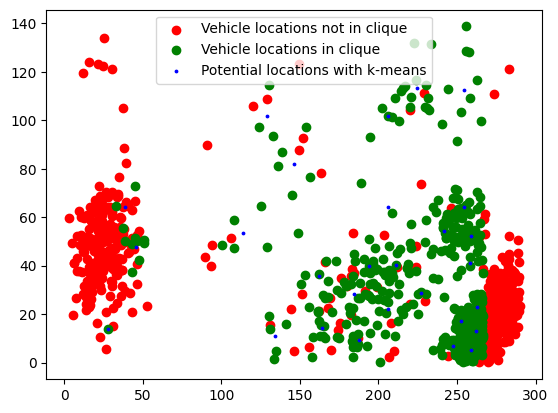

In [188]:
plt.scatter(unique_locations[~mask, 0], unique_locations[~mask, 1], c="red", label="Vehicle locations not in clique")
plt.scatter(unique_locations[mask, 0], unique_locations[mask, 1], c="green", label="Vehicle locations in clique")
plt.scatter(cluster[:, 0], cluster[:, 1], c="blue", label="Potential locations with k-means", s=3)
plt.legend()
plt.show()